# A simple 2D Riemannian Flow Matching model on sphere

## Imports and init device

In [1]:
import time
import torch
import math
import numpy as np

from torch import nn, Tensor

# flow_matching
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.solver import ODESolver, RiemannianODESolver
from flow_matching.utils import ModelWrapper
from flow_matching.utils.manifolds import Sphere, Manifold

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using cpu.


In [3]:
torch.manual_seed(42)

## Dataset

In [4]:
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    x1 = torch.rand(batch_size, device=device) * 2 - 2
    x3 = torch.rand(batch_size, device=device) * 0.01 - 2
    x2_ = (torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2)
    x2 = x2_ + (torch.floor(x1) % 2)

    data = torch.cat([x1[:, None], x2[:, None], x3[:, None]], dim=1)

    return data.float()

def wrap(manifold, samples):
    center = torch.cat([torch.zeros_like(samples), torch.ones_like(samples[..., 0:1])], dim=-1)
    samples = torch.cat([samples, torch.zeros_like(samples[..., 0:1])], dim=-1) / 2

    return manifold.expmap(center, samples)

# out = inf_train_gen()

# manifold = Sphere()
# out = wrap(manifold, out)
# plot_orientations(out, offset=0)

In [5]:
# out = inf_train_gen()

# from scipy.spatial.transform import Rotation
# rotations = Rotation.from_quaternions(out.cpu().numpy())

# from flow_matching.utils.manifolds import SO3
# manifold = SO3()
# out = wrap(manifold, out)

# from my_circles.data import plot_orientations

# plot_orientations(out, offset=0)



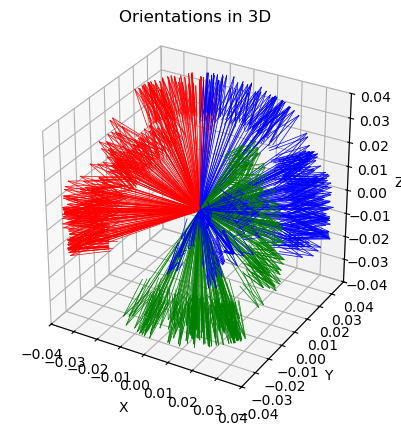

In [6]:
out = inf_train_gen()

manifold = Sphere()
out = wrap(manifold, out)

from my_circles.data import plot_orientations

plot_orientations(out, offset=0)


## Model

In [7]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x


# Model class
class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int = 2,
        time_dim: int = 1,
        hidden_dim: int = 128,
        output_dim: int = None,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim
        if output_dim is None:
            output_dim = input_dim

        self.input_layer = nn.Linear(input_dim + time_dim, hidden_dim)

        self.main = nn.Sequential(
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        # sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        h = self.input_layer(h)
        output = self.main(h)

        return output #.reshape(*sz)


class ProjectToTangent(nn.Module):
    """Projects a vector field onto the tangent plane at the input."""

    def __init__(self, vecfield: nn.Module, manifold: Manifold):
        super().__init__()
        self.vecfield = vecfield
        self.manifold = manifold

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        x = self.manifold.projx(x)
        v = self.vecfield(x, t)
        v = self.manifold.proju(x, v)
        return v

## Train Velocity Flow Matching model

In [8]:
# training arguments
lr = 0.001
batch_size = 4096
iterations = 2001 #5001
print_every = 100
manifold = Sphere()
dim = 4
hidden_dim = 512

# velocity field model init
vf = ProjectToTangent(  # Ensures we can just use Euclidean divergence.
    MLP(  # Vector field in the ambient space.
        input_dim=dim,
        hidden_dim=hidden_dim,
    ),
    manifold=manifold,
)
vf.to(device)

# instantiate an affine path object
path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)




from flow_matching.path import CompositeGeodesicProbPath, SO3ProbPath

from scipy.spatial.transform import Rotation
from flow_matching.utils.manifolds import SO3
manifold = SO3()

vf = MLP(input_dim=9, hidden_dim=hidden_dim, output_dim=3)
vf.to(device)

path = SO3ProbPath(scheduler=CondOTScheduler())


TRAIN = True
if not TRAIN:
    # load the model from disk
    vf.load_state_dict(torch.load('vf.pth'))

else:
    # init optimizer
    optim = torch.optim.Adam(vf.parameters(), lr=lr) 

    # train
    start_time = time.time()
    for i in range(iterations):
        optim.zero_grad() 

        # # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
        x_1 = inf_train_gen(batch_size=batch_size, device=device) # sample data
        x_0 = torch.randn_like(x_1).to(device)

        x_1 = wrap(Sphere(), x_1)
        x_0 = wrap(Sphere(), x_0)


        x_1 = torch.Tensor(Rotation.from_quat(x_1.cpu().numpy()).as_matrix()).flatten(-2, -1).to(device)
        x_0 = torch.Tensor(Rotation.random(x_1.shape[0]).as_matrix()).flatten(-2, -1).to(device)

        # sample time (user's responsibility)
        t = torch.rand(x_1.shape[0]).to(device) 

        # sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

        # flow matching l2 loss
        loss = torch.pow( vf(path_sample.x_t, path_sample.t) - path_sample.dx_t, 2).mean()

        # optimizer step
        loss.backward() # backward
        optim.step() # update
        
        # log loss
        if (i+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
                .format(i+1, elapsed*1000/print_every, loss.item())) 
            start_time = time.time()

| iter    100 | 39.99 ms/step | loss    0.360 
| iter    200 | 39.03 ms/step | loss    0.326 
| iter    300 | 38.80 ms/step | loss    0.315 
| iter    400 | 39.19 ms/step | loss    0.293 
| iter    500 | 40.57 ms/step | loss    0.289 
| iter    600 | 41.65 ms/step | loss    0.295 
| iter    700 | 40.18 ms/step | loss    0.291 
| iter    800 | 40.27 ms/step | loss    0.290 
| iter    900 | 38.13 ms/step | loss    0.271 
| iter   1000 | 38.36 ms/step | loss    0.283 
| iter   1100 | 42.20 ms/step | loss    0.283 
| iter   1200 | 40.61 ms/step | loss    0.288 
| iter   1300 | 41.07 ms/step | loss    0.272 
| iter   1400 | 39.02 ms/step | loss    0.276 
| iter   1500 | 39.73 ms/step | loss    0.278 
| iter   1600 | 40.47 ms/step | loss    0.282 
| iter   1700 | 41.05 ms/step | loss    0.278 
| iter   1800 | 40.88 ms/step | loss    0.283 
| iter   1900 | 40.39 ms/step | loss    0.269 
| iter   2000 | 40.67 ms/step | loss    0.269 


#### Sample from trained model

In [9]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x=x, t=t)

wrapped_vf = WrappedModel(vf)

In [10]:
# # save the model to disk
# torch.save(vf.state_dict(), 'vf.pth')
# vf(path_sample.x_t, path_sample.t).shape

# x_init.shape



In [12]:
# step size for ode solver
step_size = 0.01
N = 6

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 500 #50000  # batch size
eps_time = 1e-2
T = torch.linspace(0, 1, N)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, 3), dtype=torch.float32, device=device)
x_init = wrap(Sphere(), x_init)
x_init = torch.Tensor(Rotation.random(batch_size).as_matrix()).flatten(-2, -1).to(device)

solver = RiemannianODESolver(velocity_model=wrapped_vf, manifold=manifold)  # create an ODESolver class
sol = solver.sample(
    x_init=x_init,
    step_size=step_size,
    method="midpoint",
    return_intermediates=True,
    time_grid=T,
    verbose=True,
)

100%|██████████| 100/100 [00:00<00:00, 224.43it/s]


### Visualize the path

(7, 500, 9)
[[1.7319641 1.7319641 1.7319641 ... 1.7319642 1.7319641 1.7319641]
 [1.7318479 1.7318467 1.7318461 ... 1.7318476 1.731847  1.7318469]
 [1.7318455 1.7318412 1.731839  ... 1.7318443 1.7318426 1.731842 ]
 ...
 [1.731848  1.7318288 1.7318271 ... 1.7318383 1.7318364 1.731831 ]
 [1.731847  1.7318321 1.731827  ... 1.7318431 1.7318434 1.7318451]
 [1.7320508 1.7320508 1.7320508 ... 1.7320508 1.7320508 1.7320508]]
max 1.732050895690918
min 1.7318217754364014
0
1
2
3
4
5
6


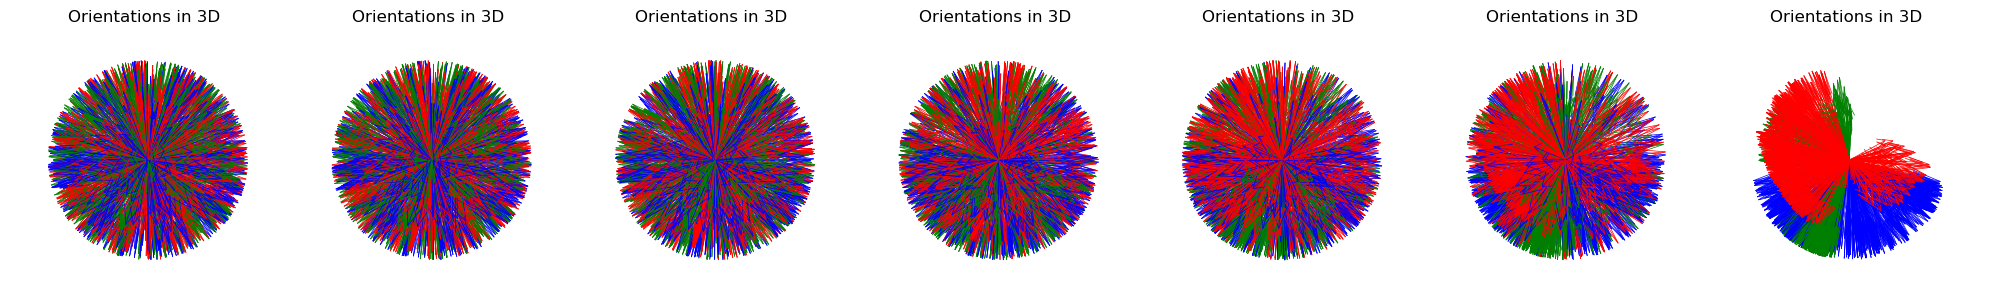

In [14]:
sol = sol.cpu()
T = T.cpu()

gt_samples = inf_train_gen(batch_size=batch_size)  # sample data
gt_samples = wrap(Sphere(), gt_samples)

gt_samples = torch.Tensor(Rotation.from_quat(gt_samples.cpu().numpy()).as_matrix()).flatten(-2, -1).to(device)

samples = torch.cat([sol, gt_samples[None]], dim=0).numpy()

print(samples.shape)
norms = np.linalg.norm(samples, axis=-1)
print(norms)
print(f"max {np.max(norms)}")
print(f"min {np.min(norms)}")

_, axs = plt.subplots(1, N + 1, figsize=(20, 3.2), subplot_kw={"projection": "3d"})

for i in range(N + 1):
    
    # plot_orientations(samples[i], axs[i], offset=0.0)


    plot_orientations(Rotation.from_matrix(samples[i].reshape(-1, 3, 3)).as_quat(), axs[i], offset=0.0)

    

    # Set the aspect ratio to equal for better visualization of a sphere
    axs[i].set_box_aspect([1, 1, 1])
    axs[i].view_init(elev=130, azim=0)
    axs[i].axis("off")

    print(i)

plt.tight_layout()
plt.show()

